In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd
from src.single_vae import VAE
from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import hnswlib

def _tanh_scale(x,scale=10,center=0.5):
    return center + (1-center) * np.tanh(scale * (x - center))

def _united_proj(wpca1, wpca2, k=20, metric="cosine", ef=200, M=48):

    metric = 'l2' if metric == 'euclidean' else metric
    metric = 'cosine' if metric == 'correlation' else metric
    labels2 = np.arange(wpca2.shape[0])
    p2 = hnswlib.Index(space=metric, dim=wpca2.shape[1])
    p2.init_index(max_elements=wpca2.shape[0], ef_construction=ef, M=M)
    p2.add_items(wpca2, labels2)
    p2.set_ef(ef)
    idx1, dist1 = p2.knn_query(wpca1, k=k)

    if metric == 'cosine':
        dist1 = 1 - dist1
        dist1[dist1 < 1e-3] = 1e-3
        dist1 = dist1/dist1.max(1)[:,None]
        dist1 = _tanh_scale(dist1,scale=10, center=0.7)
    else:
        sigma1 = dist1[:,4]
        sigma1[sigma1<1e-3]=1e-3
        dist1 = np.exp(-dist1/sigma1[:,None])
        
    Sim1 = dist1  # np.exp(-1*(1-dist1)**2)
    knn1v2 = sp.sparse.lil_matrix((wpca1.shape[0], wpca2.shape[0]))
    x1 = np.tile(np.arange(idx1.shape[0])[:, None], (1, idx1.shape[1])).flatten()
    knn1v2[x1.astype('int32'), idx1.flatten().astype('int32')] = Sim1.flatten()
    return knn1v2.tocsr()

from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
species_data_sub = pickle.load(open('data.p','rb'))

adata1 = species_data_sub['fish']
adata2 = species_data_sub['frog']

batch_size = 256

data_module = CrossSpeciesDataModule(
    species_data = species_data_sub,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    yield_pairwise=False,
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes
homology_edges, homology_scores = pickle.load(open('homology_zfxe.p','rb'))


early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)



model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    batch_size=batch_size,
    
    # Loss weights
    direct_recon_weight=1.0,
    cross_species_recon_weight=1.0,
    gmm_weight=0e-2,
    # init_beta=1e-6,
    # final_beta=1e-3,
    
    # Testing
    n_clusters=100,
    clusterer_warmup_epochs=3,
    initial_sigma=3.0,
    initialize_with_gmm=True, # when true, initial sigma isn't used fyi
    use_parametric_clusterer=True,


    # Learning rate
    base_learning_rate=5e-3,
    min_learning_rate=5e-5,    
    warmup_data=0.1,
    
    # Homology dropout
    homology_dropout_rate=0.2,
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=30,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model, data_module)
print(trainer.current_epoch)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. I

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s, v_num=269]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s, v_num=269]   

Metric val_loss improved. New best score: 0.829


Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, v_num=269]   

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.796


Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, v_num=269]   

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.772


Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s, v_num=269]   

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.759


Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, v_num=269]   

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.743


Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s, v_num=269]   

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.737


Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  6.10it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s, v_num=269]   

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.735


Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  6.09it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, v_num=269]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s, v_num=269]   

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.730


Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  6.09it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s, v_num=269]   

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.727


Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s, v_num=269]  

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.725


Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s, v_num=269]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.722


Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, v_num=269]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s, v_num=269]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.720


Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s, v_num=269]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, v_num=269]  

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.719


Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, v_num=269]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.717


Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s, v_num=269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s, v_num=269]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  6.13it/s, v_num=269]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, v_num=269]  

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.717. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 32/32 [00:06<00:00,  4.78it/s, v_num=269]
20


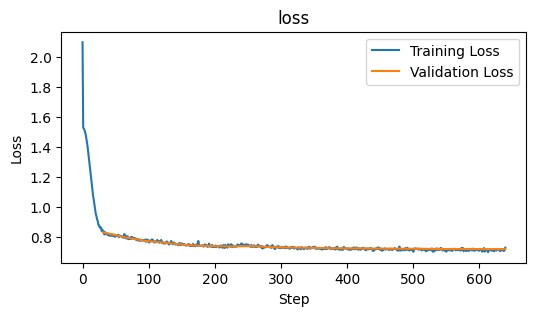

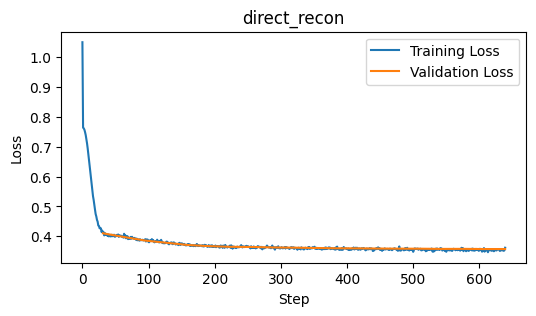

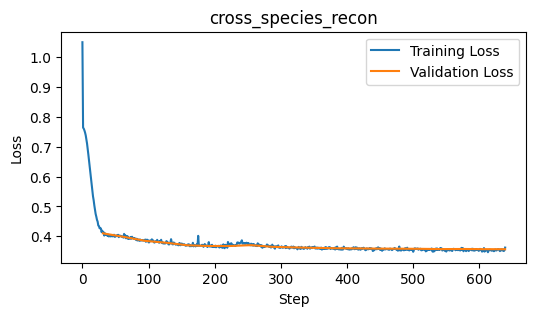

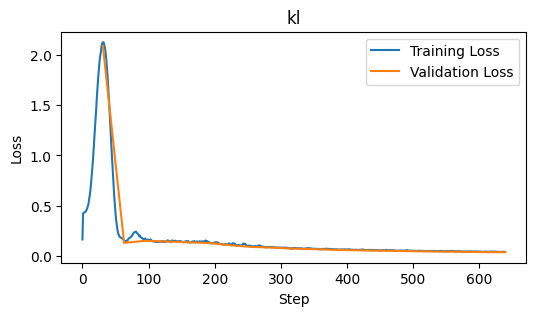

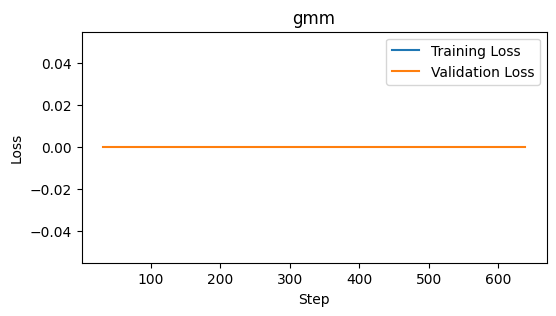

In [4]:
,# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["loss", "direct_recon", "cross_species_recon", "kl", "gmm"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}']#[df[f'val_{loss_type}'] != 0.0]
    val_step = df['step']#[df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

Species 1 0.3742092885124973 0.6579316036677916
Species 2 0.2882583674736333 0.5862509216668523
Cross species 0.2070992116751293
Cross species 1 0.33599609754243903 0.553875839647331
Cross species 1 leiden 0.40512979285389544 0.6210802291656061
Cross species 2 0.15182816463872126 0.4396865632979087
Cross species 2 leiden 0.29883920443536993 0.5860130803465154


/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


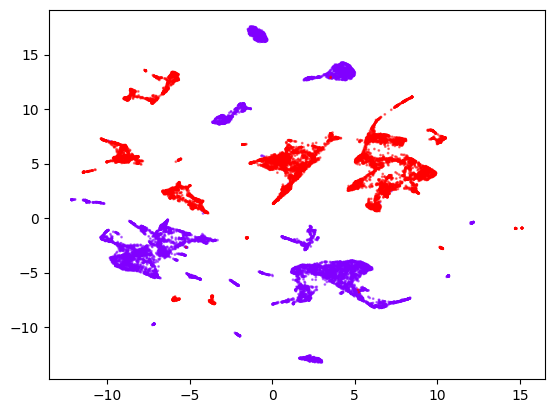

In [5]:
output, s, memberships = model.get_latent_embeddings(species_data_sub, batch_size=4096)
latent = output.cpu().numpy()
s=s.cpu().numpy()

#output, s = model.get_latent_embeddings(species_data)
#s=s.cpu().numpy()

#plt.figure();
#dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
#plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1], [species_data_sub['fish'], species_data_sub['frog']], ['cell_type', 'cell_type']):
    # dt = dt_full[s==i] # umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = latent[s==i]
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(f"Species {i+1}", adjusted_rand_score(adata.obs[key], adata.obs['leiden']), adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
#     plt.figure();
#     plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')

nnm1v2 = _united_proj(latent[s==0],latent[s==1], k=15, metric='cosine')
nnm2v1 = _united_proj(latent[s==1],latent[s==0], k=15, metric='cosine')

sc.pp.neighbors(adata, use_rep='emb')
adata.obsp['connectivities'] = sp.sparse.vstack((sp.sparse.hstack((sp.sparse.csr_matrix((nnm1v2.shape[0],nnm1v2.shape[0])), nnm1v2)),
sp.sparse.hstack((nnm2v1, sp.sparse.csr_matrix((nnm2v1.shape[0],nnm2v1.shape[0]))))))
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
print("Cross species", adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden']))

x,y = nnm1v2.nonzero()
cl1 = np.array(list(adata1.obs['cell_type']))
cl2 = np.array(list(adata2.obs['cell_type']))

a = cl2[y.reshape((nnm1v2.shape[0], 15))]
cl1_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl1_new.append(b[np.argmax(v)])

cl1_new = np.array(cl1_new)

print("Cross species 1", adjusted_rand_score(adata1.obs['cell_type'], cl1_new), adjusted_mutual_info_score(adata1.obs['cell_type'], cl1_new))
print("Cross species 1 leiden", adjusted_rand_score(adata1.obs['leiden'], cl1_new), adjusted_mutual_info_score(adata1.obs['leiden'], cl1_new))

x,y = nnm2v1.nonzero()

a = cl1[y.reshape((nnm2v1.shape[0], 15))]
cl2_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl2_new.append(b[np.argmax(v)])

cl2_new = np.array(cl2_new)

print("Cross species 2", adjusted_rand_score(adata2.obs['cell_type'], cl2_new), adjusted_mutual_info_score(adata2.obs['cell_type'], cl2_new))
print("Cross species 2 leiden", adjusted_rand_score(adata2.obs['leiden'], cl2_new), adjusted_mutual_info_score(adata2.obs['leiden'], cl2_new))

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

In [6]:
c_memberships = memberships.detach().cpu().numpy()
c = np.argmax(c_memberships,axis=1)

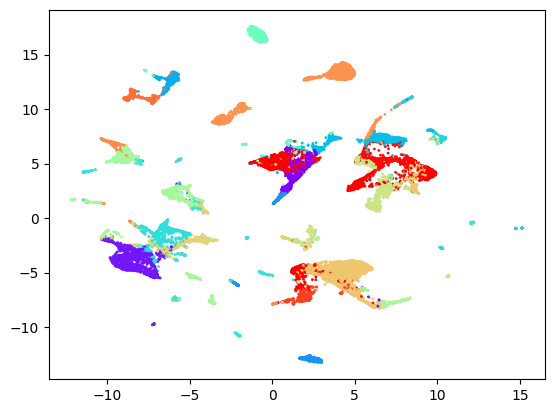

In [7]:
plt.figure(); plt.scatter(dt_full[:,0],dt_full[:,1],c=c,cmap='rainbow',s=1);

/tmp/ipykernel_1291108/3351005440.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(); plt.scatter(dt_full[c==I,0],dt_full[c==I,1],c=s[c==I],cmap='rainbow',s=1); plt.title(I);


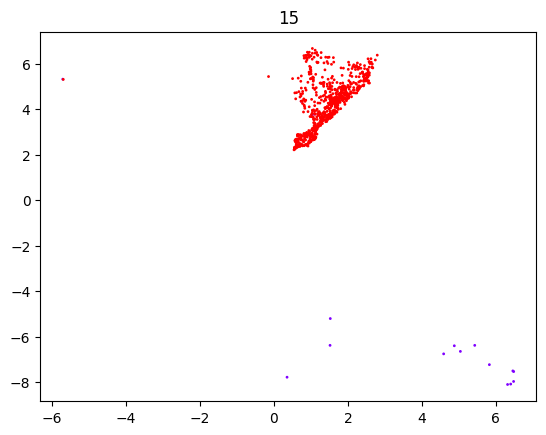

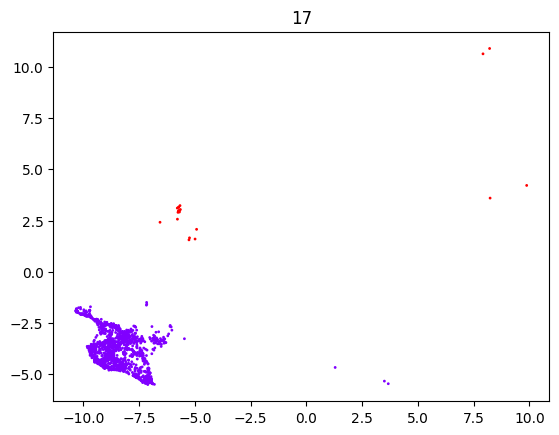

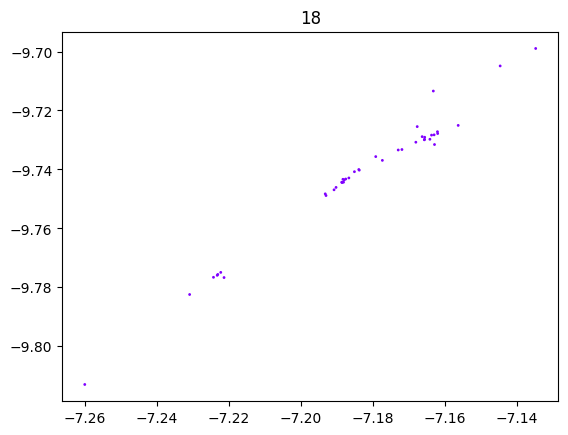

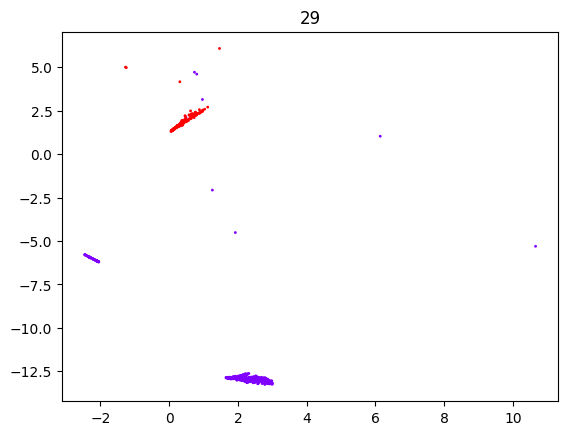

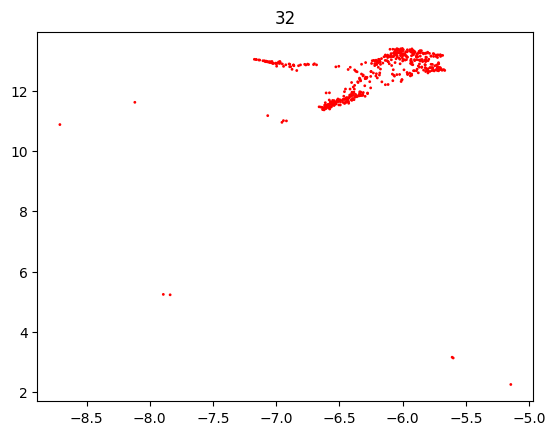

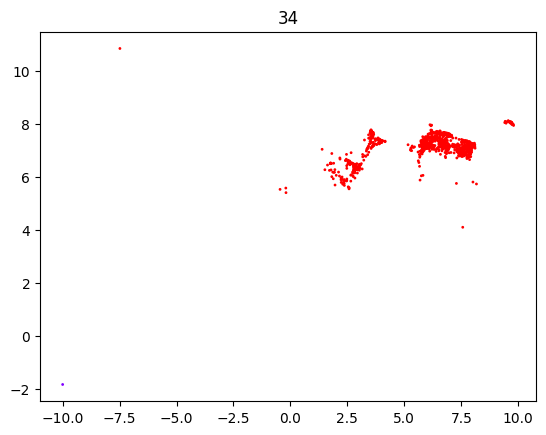

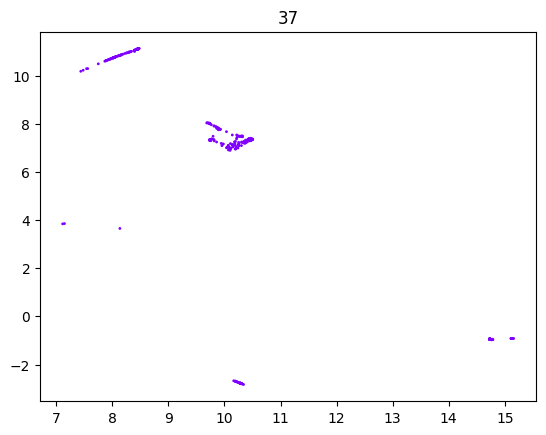

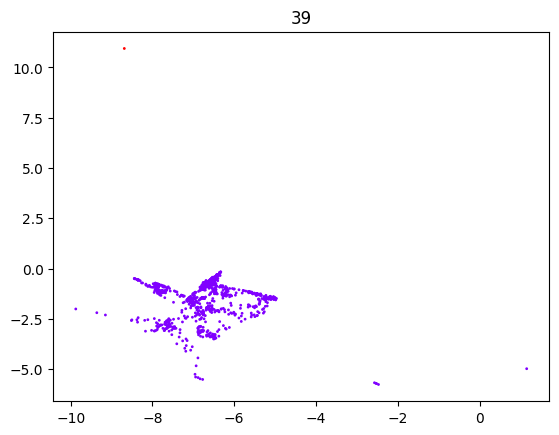

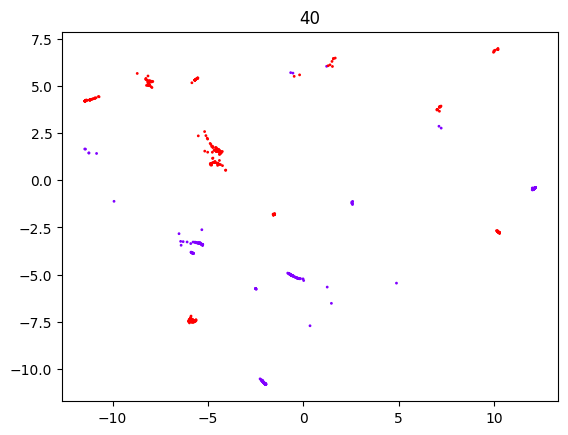

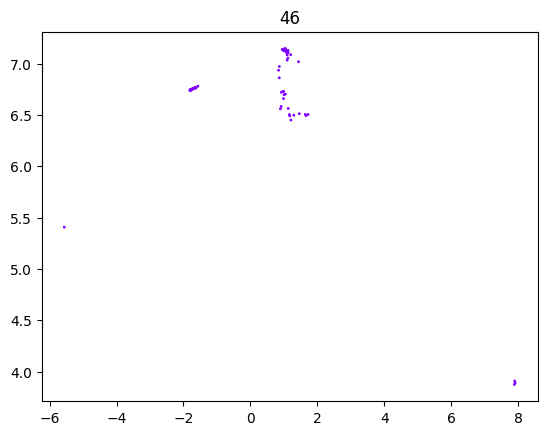

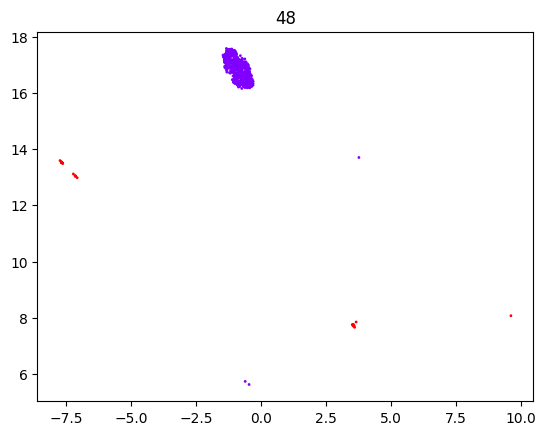

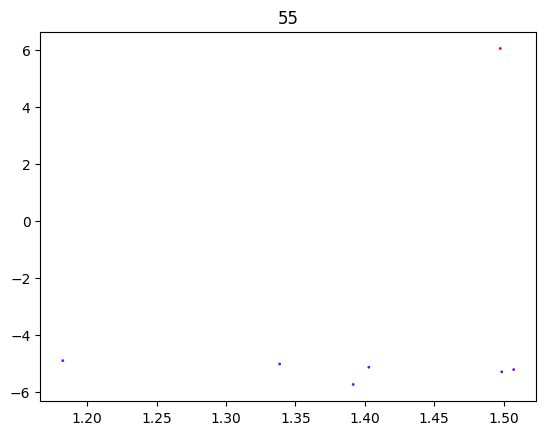

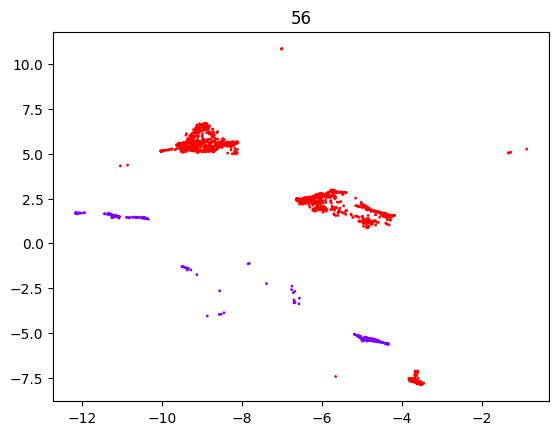

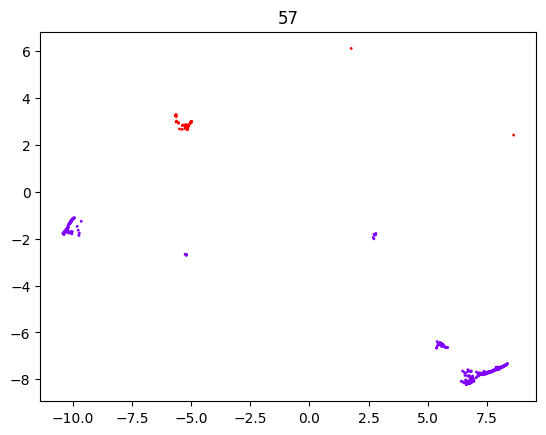

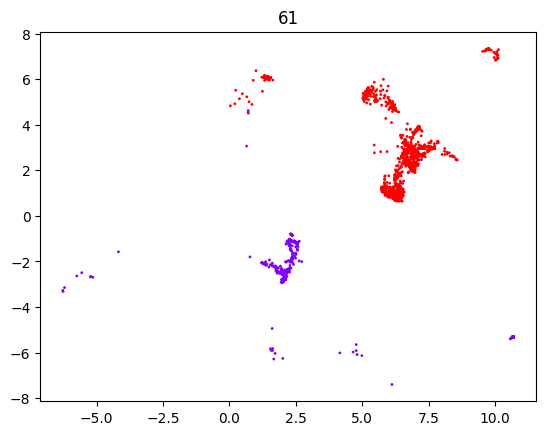

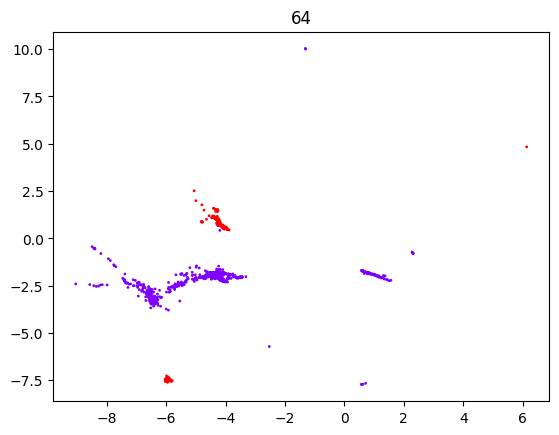

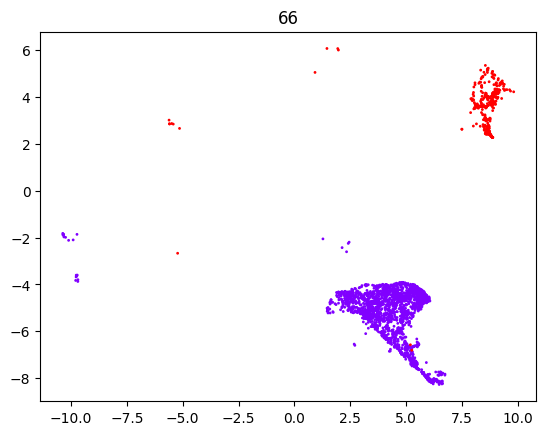

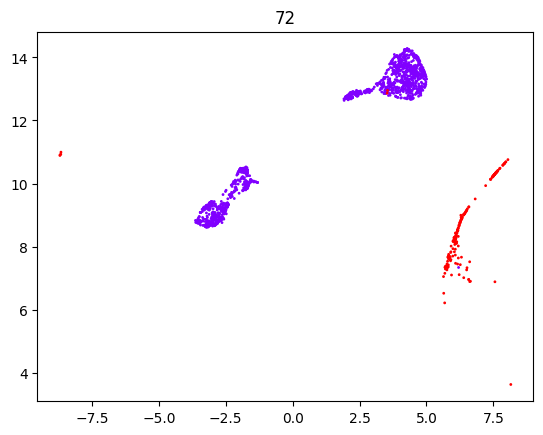

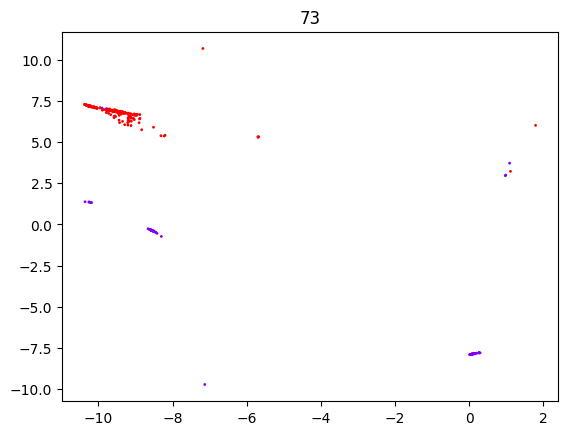

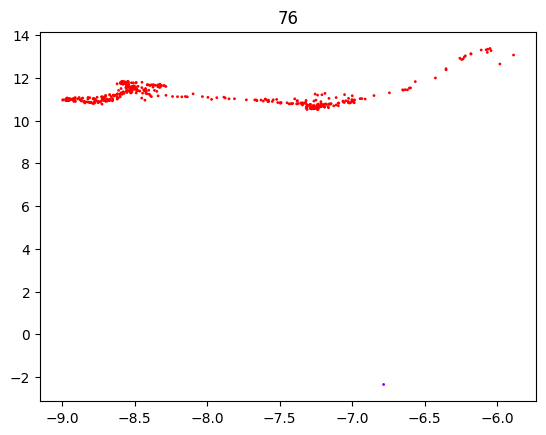

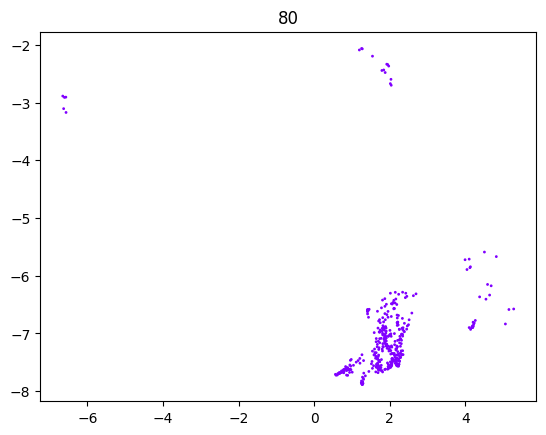

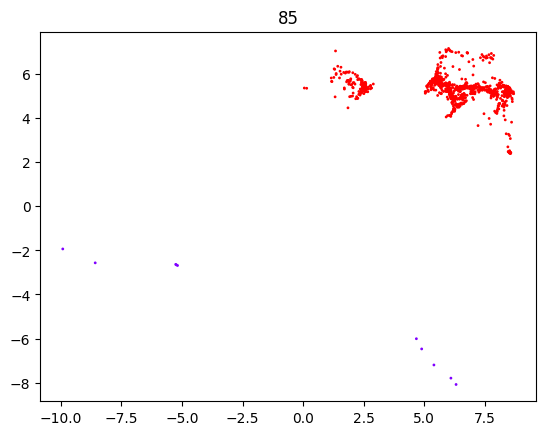

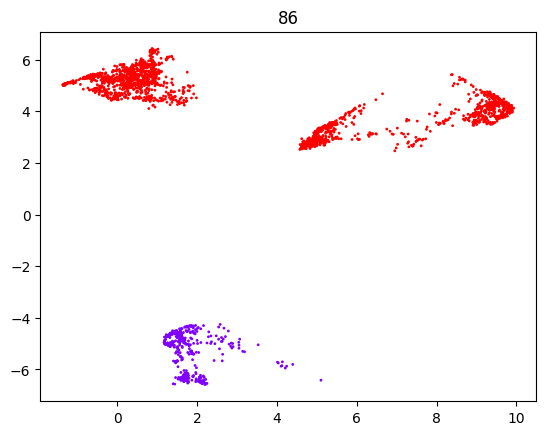

In [20]:
for I in (np.unique(c)):
    if (c==I).sum() < 5:
        continue
    plt.figure(); plt.scatter(dt_full[c==I,0],dt_full[c==I,1],c=s[c==I],cmap='rainbow',s=1); plt.title(I);

In [8]:
adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],c[s==0]), adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],species_data_sub['fish'].obs['leiden'])

(0.5912362291941364, 0.6579316036677916)

In [9]:
adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],c[s==1]), adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],species_data_sub['frog'].obs['leiden'])

(0.451328112076968, 0.5862509216668523)

In [10]:
torch.exp(model.clusterer.log_sigma).max(), torch.exp(model.clusterer.log_sigma).min()

(tensor(3.4159, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.4414, device='cuda:0', grad_fn=<MinBackward1>))

In [11]:
x,y = np.unique(c,return_counts=True)
x[y>5].size

23

In [12]:
from sklearn.cluster import KMeans

labels = KMeans(n_clusters=100).fit_predict(output.cpu().numpy())

In [13]:
adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],labels[s==0]), adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],species_data_sub['fish'].obs['leiden'])

(0.6237107462006404, 0.6579316036677916)

In [14]:
adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],labels[s==1]), adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],species_data_sub['frog'].obs['leiden'])

(0.5729770369541729, 0.5862509216668523)

In [15]:
z=[]
for i in np.unique(labels):
    v = s[labels==i]
    j = (v==0).mean()
    z.append(max(j,1-j))
    
np.mean(z)

0.9725384199557672

In [16]:
z=[]
for i in np.unique(c):
    v = s[c==i]
    j = (v==0).mean()
    z.append(max(j,1-j))
    
np.mean(z)

0.8908990433433308

In [17]:
torch.exp(model.clusterer.log_sigma)

tensor([2.1065, 1.5546, 1.8168, 1.8621, 1.6850, 3.0074, 2.0108, 2.4279, 1.6910,
        2.1215, 3.0252, 1.7136, 1.6765, 1.5307, 1.8606, 1.7137, 1.6233, 2.0432,
        3.1850, 1.8080, 1.8098, 3.2303, 1.6421, 1.4542, 2.0887, 2.2328, 1.8065,
        1.7378, 1.8746, 2.8808, 1.8846, 1.5387, 2.6587, 1.9127, 2.4154, 1.6076,
        2.6637, 2.9828, 2.2853, 2.2087, 2.6321, 2.1605, 1.7144, 1.6623, 1.8957,
        2.0578, 2.0770, 1.7311, 2.6946, 1.5875, 1.7338, 1.6248, 1.7488, 1.8286,
        2.2736, 3.1700, 2.1281, 2.8804, 1.6961, 1.8015, 2.0481, 2.0078, 1.8176,
        2.7949, 2.4314, 1.5559, 2.7955, 1.8708, 2.2674, 3.4159, 1.4717, 1.6362,
        2.3296, 1.9155, 1.6688, 1.9767, 1.7761, 2.1907, 1.9160, 1.8620, 2.1875,
        2.9466, 1.5933, 2.1352, 3.1510, 2.2374, 1.7566, 1.8721, 2.0973, 1.7657,
        2.0896, 1.9707, 2.2402, 1.9265, 1.7067, 1.4414, 1.5662, 1.7621, 2.2722,
        3.1690], device='cuda:0', grad_fn=<ExpBackward0>)

In [18]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

2025-01-01 19:35:59,950 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-01 19:36:02,312 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-01 19:36:02,355 - harmonypy - INFO - Iteration 1 of 10
2025-01-01 19:36:06,540 - harmonypy - INFO - Iteration 2 of 10
2025-01-01 19:36:10,655 - harmonypy - INFO - Iteration 3 of 10
2025-01-01 19:36:14,460 - harmonypy - INFO - Iteration 4 of 10
2025-01-01 19:36:18,881 - harmonypy - INFO - Iteration 5 of 10
2025-01-01 19:36:22,860 - harmonypy - INFO - Iteration 6 of 10
2025-01-01 19:36:26,578 - harmonypy - INFO - Iteration 7 of 10
2025-01-01 19:36:30,711 - harmonypy - INFO - Iteration 8 of 10
2025-01-01 19:36:34,608 - harmonypy - INFO - Iteration 9 of 10
2025-01-01 19:36:38,490 - harmonypy - INFO - Iteration 10 of 10
2025-01-01 19:36:42,350 - harmonypy - INFO - Stopped before convergence
/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.p

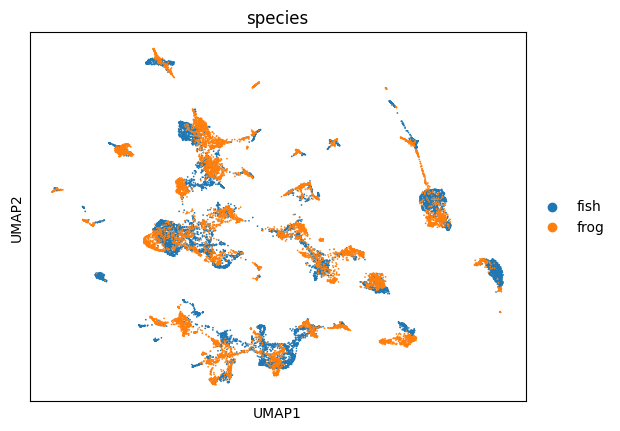

In [19]:
sc.pl.umap(adata,color='species')

The best results so far were with repulsion loss on and k-means init after 5 epochs (so end of epoch 4). 

Centroids NOT detached.
We used MU and not Z for memberships.


Now: Trying without k-means init, still using MU
 -- WITH REPULSIVE PRIOR HERE, WE GET 1 CLUSTER THROUGHOUT. WITHOUT, WE GET SOME CLUSTER UTILIZATION BUT IT'S SLOW TO LEARN.
Next: Either try with k-means init AND Z or without AND Z

No repulsion = higher utilization of clusters

COMPARE FINAL RESULTS WITH JUST USING K-MEANS FOR THE SAME NUMBER OF CLUSTERS ON FINAL LATENTS


Observations:
1. Repulsion (with usage scaling) leads to fewer clusters.
2. K-means initialization is important for good performance (5 epoch warmup)
3. Running k-means on the final latents gives slightly better accuracy than using the VAE-optimized memberships, but very poor mixing across species. VAE-optimized memberships gives a little better mixing.
4. Using "z" instead of "mu" for memberships gives worse clustering performance
5. Using "mu" instead of "z" for reconstruction and membership yields lots of clusters (88 / 100) & faster convergence. Accuracy is ~slightly worse, but slightly only.
6. Using "z" for embedding (sampled latent) gives great integration but very poor clustering accuracy (clusters are more mixed).

Clustering "z" (getting membership scores) gives better mixing across species because "z" is better-mixed across species. But the resulting clusters are less accurate for within-species clustering.

Clustering "mu" gives better clustering accuracy but worse mixing.

Using turning the VAE into an AE gives slightly better mixing across species in clusters and similar clustering accuracy.
Interestingly, using "z" for latents and "mu" for memberships in decoder reconstruction gives similar clustering accuracy but much worse mixing

Adding back the KL prior, though, gives even better mixing across species (~0.92)

Ok WOW: Harmony does WAAYYYYY better when using VAE mode. AE mode is WAAAAY worse.

Adding dropout to transformation makes harmony worse, btw.


You need to rethink the clustering. Current approach is highly unstable - different clusterings each time, it seems like, though not verified experimentally. I did observe this between a couple runs, though, that the species mixture per cluster was 0.98 vs 0.88 between two runs.

In [27]:
def generate_label_similarity_matrix(latent, s, i, j, name1, name2, K):
    nnm = _united_proj(latent[s==j],latent[s==i], k=K, metric='cosine')
    x, y = nnm.nonzero()
    indices_x = x.reshape((nnm.shape[0],K))
    indices_y = y.reshape((nnm.shape[0],K))
    similarities = nnm.data.reshape((nnm.shape[0],K))


    cl1 = np.array(list(species_data_sub['fish'].obs[name1]))
    cl2 = np.array(list(species_data_sub['frog'].obs[name2]))

    clu1,cluc1 = np.unique(cl1, return_counts=True)
    clu2,cluc2 = np.unique(cl2, return_counts=True)

    C = np.zeros((clu1.size,clu2.size))

    
    df = pd.DataFrame();
    df['labels_0'] = cl1[indices_y].flatten()
    df['labels_1'] = cl2[indices_x].flatten()
    df['similarities'] = similarities.flatten()
    df = df.groupby(['labels_0','labels_1']).sum().reset_index()

    C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
    C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)
    
    return C, clu1, clu2


def format_cross_species_similarities(
    similarity_matrix: np.ndarray,
    source_labels: np.ndarray,
    target_labels: np.ndarray,
    source_species: str = "fish",
    target_species: str = "frog",
    top_n: int | None = None
) -> pd.DataFrame:
    """
    Format similarity matrix into a DataFrame with columns for each species-cell type combination.
    
    Args:
        similarity_matrix: NxM matrix of similarities
        source_labels: N labels from source species
        target_labels: M labels from target species
        source_species: Name of source species
        target_species: Name of target species
        top_n: Optional number of top matches to include (None for all)
    """
    # Create columns for both species
    columns = pd.MultiIndex.from_tuples(
        # Wagner columns
        [(source_species, cell_type, col_name)
         for cell_type in source_labels
         for col_name in ['matched_type', 'similarity']] +
        # Briggs columns
        [(target_species, cell_type, col_name)
         for cell_type in target_labels
         for col_name in ['matched_type', 'similarity']]
    )
    
    # Initialize DataFrame
    max_rows = max(
        len(target_labels) if top_n is None else top_n,
        len(source_labels) if top_n is None else top_n
    )
    df = pd.DataFrame(index=range(max_rows), columns=columns)
    
    # Fill Wagner -> Briggs mappings
    for i, source_label in enumerate(source_labels):
        similarities = similarity_matrix[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(source_species, source_label, 'matched_type')] = target_labels[sorted_indices]
        df[(source_species, source_label, 'similarity')] = similarities[sorted_indices]
    
    # Fill Briggs -> Wagner mappings (using transposed similarity matrix)
    similarity_matrix_T = similarity_matrix.T
    for i, target_label in enumerate(target_labels):
        similarities = similarity_matrix_T[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(target_species, target_label, 'matched_type')] = source_labels[sorted_indices]
        df[(target_species, target_label, 'similarity')] = similarities[sorted_indices]
    
    return df


In [28]:
latent = adata.obsm['X_pca_harmony']

In [29]:
species_data_sub['fish'].obs['cell_type_strip'] = pd.Categorical(['-'.join(i.split('-')[1:]) for i in species_data_sub['fish'].obs['cell_type']])
species_data_sub['frog'].obs['cell_type_strip'] = pd.Categorical(['-'.join(i.split('-')[1:]) for i in species_data_sub['frog'].obs['cell_type']])

In [30]:
K = 50
# latent = output.cpu().numpy()
C, clu1, clu2 = generate_label_similarity_matrix(latent, s, 0, 1, 'cell_type_strip', 'cell_type_strip', 50)

In [31]:
pd.set_option('display.max_columns', None)

# Create the DataFrame with top 5 matches
similarity_df1 = format_cross_species_similarities(C, clu1, clu2, top_n=5)

In [32]:
similarity_df1['frog']

Blastula                    Blood             \
         matched_type similarity  matched_type similarity   
0            Blastula   3.629611   Endothelial  10.855651   
1           Hindbrain   0.683629         Optic   3.802413   
2            Germline   0.643863         Blood   3.066602   
3  Forebrain/midbrain   0.593598  Neural crest   2.878415   
4            Endoderm   0.206630         Heart   1.986899   

   Cement gland primordium                             Endoderm             \
              matched_type similarity              matched_type similarity   
0                 periderm  17.634957                  Blastula   7.843821   
1  Rare epidermal subtypes   3.086248     Intermediate mesoderm   2.775463   
2     Epidermal progenitor   2.889042                     Heart   2.498584   
3               Macrophage   2.177815  Involuting marginal zone   2.102518   
4            Placodal area   1.982988       Presomitic mesoderm   1.393548   

             Endothelial             Epidermal progenitor             \
            matched_type similarity          matched_type similarity   
0            Endothelial   7.334965  Epidermal progenitor  20.121219   
1                  Heart   4.914299         Placodal area   6.935074   
2  Intermediate mesoderm   4.605941              Blastula   5.846003   
3           Neural crest   1.292102   Non-neural ectoderm   3.321458   
4              Notochord   0.778255         Neuroectoderm   2.740923   

       Eye primordium             Forebrain/midbrain             \
         matched_type similarity        matched_type similarity   
0              Neuron   3.442743              Neuron   3.900065   
1           Hindbrain   2.410112           Hindbrain   1.905683   
2  Forebrain/midbrain   2.175928  Forebrain/midbrain   1.515291   
3         Endothelial   1.645804  Rohon-beard neuron   1.453189   
4  Rohon-beard neuron   1.602562         Endothelial   0.934106   

                 Germline                          Goblet cell             \
             matched_type similarity              matched_type similarity   
0                Germline   0.249583                  periderm  22.136961   
1         Pronephric duct   0.213174  Involuting marginal zone   3.823273   
2  Neural crest - crestin   0.193395                  Endoderm   3.098625   
3       Olfactory placode   0.115423   Rare epidermal subtypes   2.475066   
4    Epidermal progenitor   0.104948          Dorsal organizer   2.050215   

            Hatching gland                                  Heart             \
              matched_type similarity                matched_type similarity   
0                 periderm   8.157440                 Endothelial   2.853679   
1           Hatching gland   3.362438  Neural crest - melanoblast   0.696970   
2          Pronephric duct   1.305670  Neural crest - xanthophore   0.447675   
3  Rare epidermal subtypes   0.909113                       Heart   0.228513   
4               Macrophage   0.699373                   Notoplate   0.099684   

            Hindbrain             Intermediate mesoderm             \
         matched_type similarity           matched_type similarity   
0           Hindbrain   9.460331            Endothelial  10.398142   
1              Neuron   8.627297  Intermediate mesoderm   7.758542   
2  Forebrain/midbrain   6.125262                  Optic   7.127724   
3             Tailbud   2.944860     Forebrain/midbrain   5.941499   
4  Rohon-beard neuron   0.587299           Neural crest   2.867165   

   Involuting marginal zone                            Ionocyte             \
               matched_type similarity             matched_type similarity   
0       Presomitic mesoderm  10.564562                 periderm  21.236922   
1  Involuting marginal zone   7.399211  Rare epidermal subtypes   5.189738   
2              Neural crest   3.842153                 Ionocyte   2.077696   
3             Neuroectoderm   2.870416               Macrophage   1.981860   
4  

In [56]:
similarity_df1['frog']

S08-Blastula               S10-Endoderm             \
                  matched_type similarity    matched_type similarity   
0               04hpf-Blastula   6.998164  24hpf-Germline   1.239050   
1               14hpf-Germline   0.114150  14hpf-Germline   0.872256   
2  18hpf-Intermediate mesoderm   0.072262  04hpf-Blastula   0.555348   
3               24hpf-Germline   0.062167  18hpf-Germline   0.496966   
4            18hpf-Endothelial   0.051570     14hpf-Heart   0.000000   

  S10-Involuting marginal zone                     S10-Neuroectoderm  \
                  matched_type similarity               matched_type   
0               04hpf-Blastula   7.692196             04hpf-Blastula   
1    18hpf-Presomitic mesoderm   2.650114             14hpf-Germline   
2               24hpf-Germline   1.117043             18hpf-Germline   
3               14hpf-Germline   0.935233             24hpf-Germline   
4               18hpf-Germline   0.726739  18hpf-Presomitic mesoderm   

                  S10-Non-neural ectoderm             \
  similarity                 matched_type similarity   
0  11.163950               04hpf-Blastula   9.748288   
1   0.961928               14hpf-Germline   0.963063   
2   0.948696               18hpf-Germline   0.962757   
3   0.685430               24hpf-Germline   0.566288   
4   0.389523  18hpf-Intermediate mesoderm   0.139203   

       S10-Spemann organizer                               S11-Endoderm  \
                matched_type similarity                    matched_type   
0             04hpf-Blastula   2.270512                  04hpf-Blastula   
1  18hpf-Presomitic mesoderm   1.471951  06hpf-Involuting marginal zone   
2             24hpf-Germline   1.258499                  06hpf-Germline   
3             14hpf-Germline   0.944086                  06hpf-Endoderm   
4             18hpf-Germline   0.751901             06hpf-Neuroectoderm   

                    S11-Epidermal progenitor             \
  similarity                    matched_type similarity   
0   6.168868  06hpf-Involuting marginal zone   7.481147   
1   2.611681             06hpf-Neuroectoderm   4.554577   
2   1.538665       06hpf-Non-neural ectoderm   4.316118   
3   1.073885                  06hpf-Endoderm   3.630870   
4   0.764170                 06hpf-Notochord   3.018001   

                     S11-Germline                            S11-Goblet cell  \
                     matched_type similarity                    matched_type   
0                 06hpf-Notochord   0.213683                  06hpf-Endoderm   
1  06hpf-Involuting marginal zone   0.202143          06hpf-Dorsal organizer   
2                  06hpf-Endoderm   0.184719  06hpf-Involuting marginal zone   
3            06hpf-Apoptotic-like   0.153362                          06hpf-   
4          06hpf-Dorsal organizer   0.117375                 06hpf-Notochord   

                S11-Involuting marginal zone             \
  similarity                    matched_type similarity   
0  15.552058  06hpf-Involuting marginal zone  13.098358   
1  10.876616           24hpf-Skeletal muscle   3.315796   
2   3.400677                  06hpf-Endoderm   2.733505   
3   2.438594                  04hpf-Blastula   1.482929   
4   1.862209            06hpf-Apoptotic-like   1.097341   

             S11-Ionocyte                          S11-Neuroectoderm  \
             matched_type similarity                    matched_type   
0  06hpf-Dorsal organizer   7.034402  06hpf-Involuting marginal zone   
1          06hpf-Endoderm   5.828149             06hpf-Neuroectoderm   
2         06hpf-Notochord   1.992419                  06hpf-Endoderm   
3    06hpf-Apoptotic-like   1.839513       06hpf-Non-neural ectoderm   
4  08hpf-Dorsal organizer   0.995875                 06hpf-Notochord   

                     S11-Non-neural ectoderm             \
  similarity                    matched_type similarity   
0  29.365433  06hpf-Involuting marginal zone  26.832436   
1   4.555881      